In [46]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata

# ML based Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline

In [47]:
#Load the Dataset
data = pd.read_csv("./fake_or_real_news.csv")


## Exploratory Data Analysis

In [48]:
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [50]:
data.groupby('label').size()

label
FAKE    3164
REAL    3171
dtype: int64

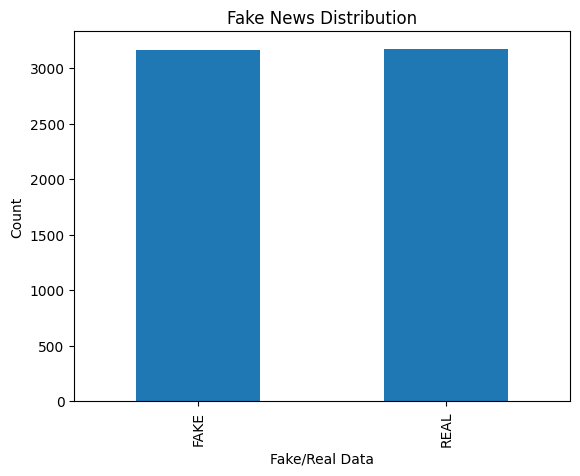

In [51]:
import matplotlib.pyplot as plt

data.groupby('label').size().plot(kind='bar')

plt.xlabel('Fake/Real Data')
plt.ylabel('Count')
plt.title('Fake News Distribution')

plt.show()

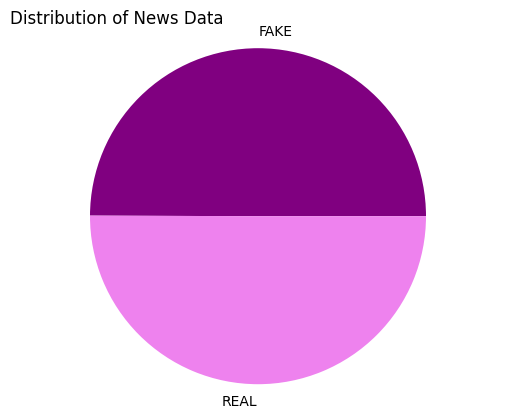

In [52]:
grouped_data = data.groupby('label').size()
colors = ['purple', 'violet']
ax = grouped_data.plot(kind='pie', colors=colors)
plt.axis('equal') 
ax.set_title('Distribution of News Data', loc='left') 
plt.ylabel('')
plt.show()


## Data Cleaning

In [53]:
# Remove Duplicates in Data
duplicatedrows = data.duplicated().sum()
print("The number of duplicated rows:", duplicatedrows)

The number of duplicated rows: 0


In [54]:
# Remove extra dataFrames
data.drop(["title"],axis=1,inplace=True)
data.drop(["Unnamed: 0"],axis=1,inplace=True)

In [55]:
# LowerCase
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,label
0,"daniel greenfield, a shillman journalism fello...",FAKE
1,google pinterest digg linkedin reddit stumbleu...,FAKE
2,u.s. secretary of state john f. kerry said mon...,REAL
3,"— kaydee king (@kaydeeking) november 9, 2016 t...",FAKE
4,it's primary day in new york and front-runners...,REAL


In [56]:
# Remove punctuation
import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [57]:
# Natural Language Tool-kit
import nltk

In [58]:
# Stopwords file path.
stopwords_file = './nltk_data/stopwords/english'

# Load the stopwords from the file.
with open(stopwords_file, 'r') as file:
    stopwords = [word.strip() for word in file.readlines()]

# Stopwords Application.
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

In [59]:
# Identify the changes made.
data.head()

,text,label
0,daniel greenfield shillman journalism fellow f...,FAKE
1,google pinterest digg linkedin reddit stumbleu...,FAKE
2,us secretary state john f kerry said monday st...,REAL
3,— kaydee king kaydeeking november 9 2016 lesso...,FAKE
4,primary day new york frontrunners hillary clin...,REAL


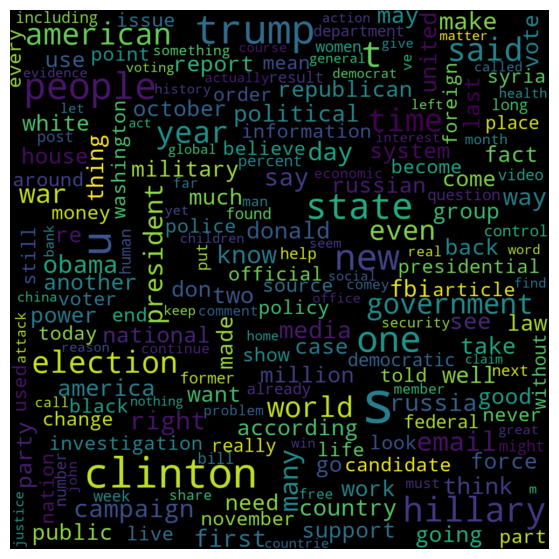

In [60]:
# Fake News Word Cloud 
from wordcloud import WordCloud

fake_data = data[data["label"] == "FAKE"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 1000, height= 1000,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

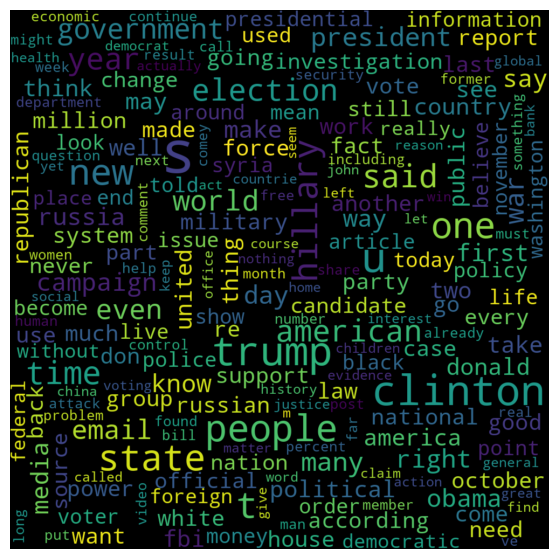

In [61]:
# Real News Word Cloud 
from wordcloud import WordCloud

real_data = data[data["label"] == "REAL"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 1000, height= 1000,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [62]:
# Counter to iterate the most used words.
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns="Frequency", n=quantity)
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=df_frequency, y="Word", x="Frequency", color='purple')  # Use y="Word" and x="Frequency"
    ax.set(xlabel="Count")
    plt.xticks(rotation='vertical')
    plt.show()


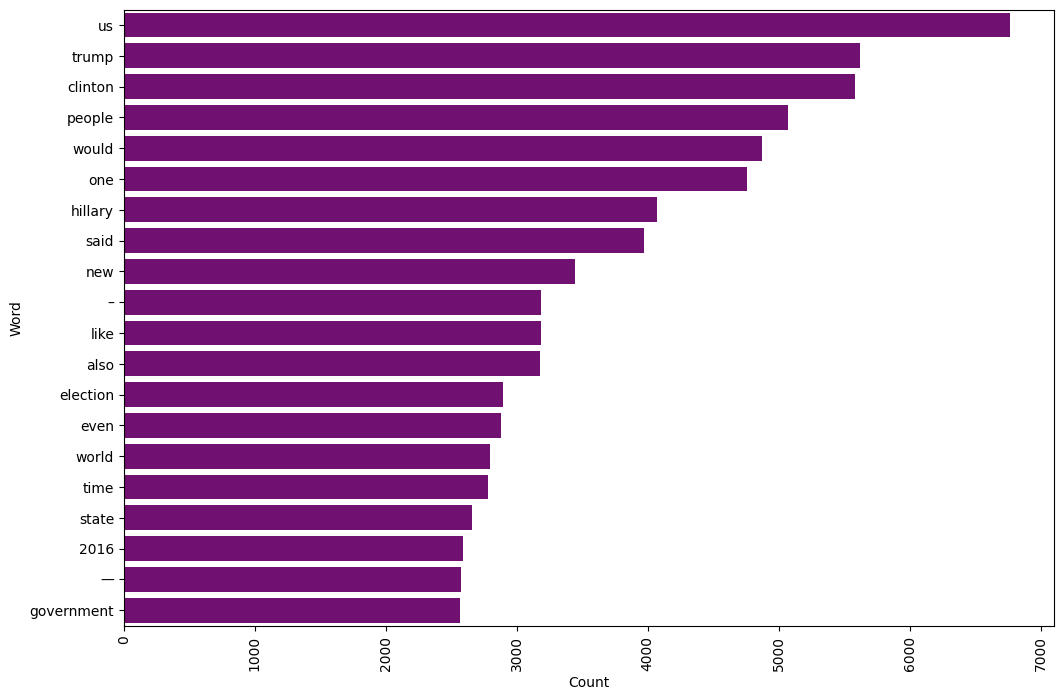

In [63]:
# Top words in Fake News with more frequency
counter(data[data["label"] == "FAKE"], "text", 20)

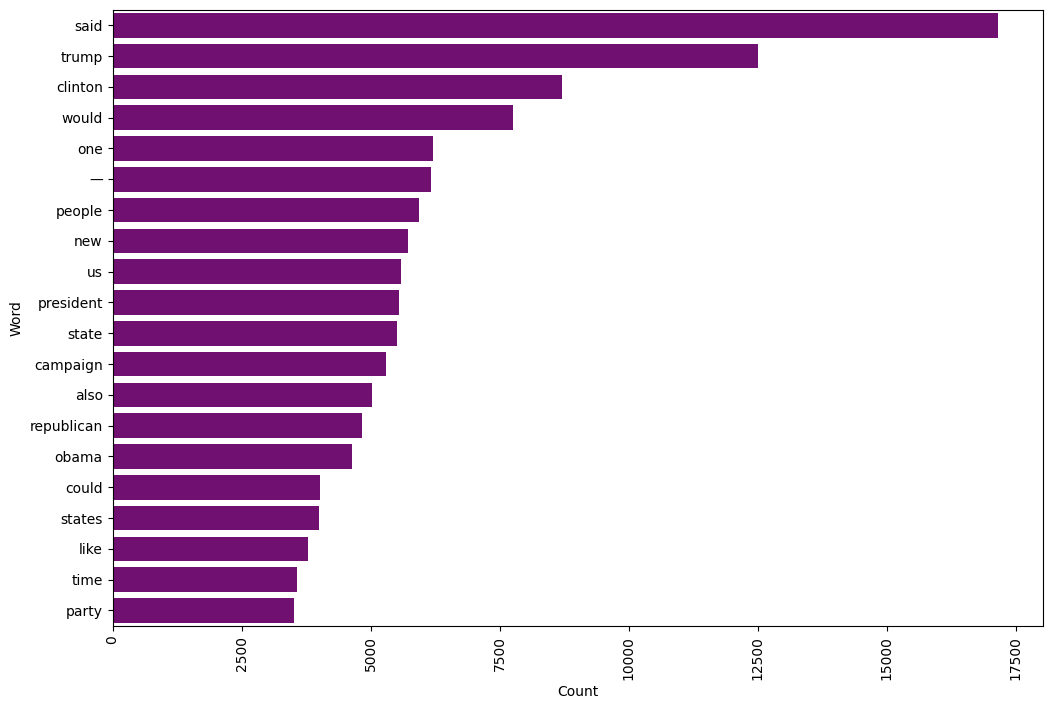

In [64]:
# Top words in Real News with more frequency
counter(data[data["label"] == "REAL"], "text", 20)

## Model Training

In [65]:
# Test and Train Split.
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.label, test_size=0.2, random_state=42)

### Logistic Regression Model

In [66]:
# Model the data using Logistic Regression model.
# Tf-idf vectorization.
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

In [67]:
# Model Fit
model = pipe.fit(X_train, y_train)

In [68]:
# Accuracy of the LR model.
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 92.34%


In [69]:
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)  # Change the color map here
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment='center',
                     color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

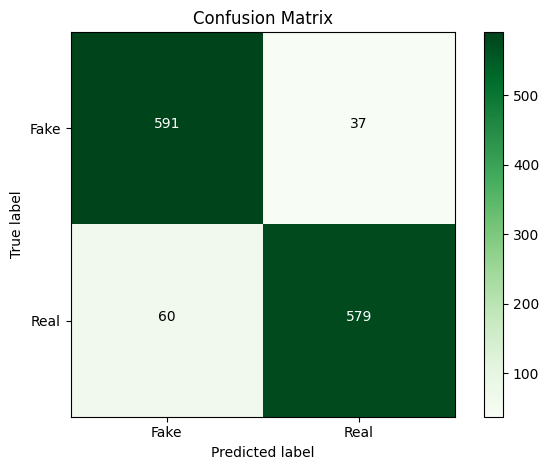

In [70]:
# Confusion matrix of the LR model.
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Decision Tree Classification Model

In [71]:
# Model the data using Decision Tree Classification model.
# Tf-idf vectorization.
from sklearn.tree import DecisionTreeClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])

In [72]:
# Model Fit
model = pipe.fit(X_train, y_train)

In [73]:
# Accuracy of the DTC model.
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 82.95%


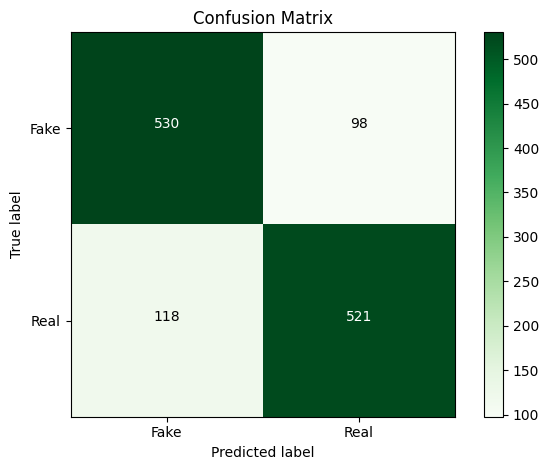

In [74]:
# Confusion matrix of the DTC model.
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Random Forest Model

In [75]:
# Model the data using Random Forest model.
# Tf-idf vectorization.

from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

In [76]:
# Model Fit
model = pipe.fit(X_train, y_train)

In [77]:
# Accuracy of the Random Forest model.
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 91.32%


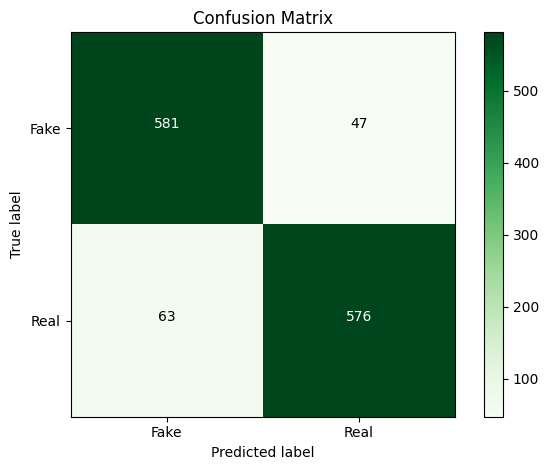

In [78]:
# Confusion matrix of the Random Forest model.
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])